### Geospatial Analysis and Outlier Detection in Election Data

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Defining the file path to my CSV file
file_path = 'Yobe election sheet.csv'

# Loading polling units data from CSV
data = pd.read_csv(file_path, encoding='latin1')

In [2]:
data

,State,LGA,Ward,PU-Code,PU-Name,Full Address,Latitude,Longitude,Accredited_Voters,Registered_Voters,...,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP
0,YOBE,BADE,GWIO-KURA,35-01-02-003,"GWIO DINA ,PRI. SCH.","YOBE BADE GWIO-KURA GWIO DINA ,PRI. SCH.",12.674848,11.066756,222,777,...,-1,True,False,False,False,UNKNOWN,17,0,18,0
1,YOBE,BADE,LAWAN FANNAMI,35-01-05-001,"ARI KULOLA, ARI KULOLA GATE","YOBE BADE LAWAN FANNAMI ARI KULOLA, ARI KULOLA...",12.878972,11.040065,184,750,...,-1,True,False,False,False,UNKNOWN,48,0,115,13
2,YOBE,BADE,LAWAN FANNAMI,35-01-05-005,TSANGAYA I OPEN SPACE,YOBE BADE LAWAN FANNAMI TSANGAYA I OPEN SPACE,12.878972,11.040065,320,1358,...,-1,True,False,False,False,UNKNOWN,73,0,221,22
3,YOBE,BADE,SARKIN HAUSAWA,35-01-07-002,TALBARI L.E.A.,YOBE BADE SARKIN HAUSAWA TALBARI L.E.A.,12.844725,11.045721,581,1935,...,-1,False,False,False,False,UNKNOWN,36,0,192,36
4,YOBE,BADE,TAGALI/SUGUM,35-01-08-007,MADAMUWA BULAMA GATE,YOBE BADE TAGALI/SUGUM MADAMUWA BULAMA GATE,12.750904,10.642180,193,572,...,-1,True,False,False,False,UNKNOWN,119,0,43,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,YOBE,NANGERE,TIKAU,35-12-10-020,"JAKADAI II K,K KOFAR MAIGARI IV","YOBE NANGERE TIKAU JAKADAI II K,K KOFAR MAIGAR...",11.771238,11.086381,51,168,...,-1,True,True,False,False,UNKNOWN,6,0,39,2
118,YOBE,NGURU,BULABULIN,35-13-01-018,COLLEGE OF EDUCATION,YOBE NGURU BULABULIN COLLEGE OF EDUCATION,12.853903,10.479001,23,72,...,-1,True,False,False,False,UNKNOWN,3,7,5,3
119,YOBE,NGURU,KANURI,35-13-07-015,TUBORI JUCTION HAND PUMP,YOBE NGURU KANURI TUBORI JUCTION HAND PUMP,12.877511,10.456516,50,91,...,-1,True,True,False,False,UNKNOWN,23,0,20,7
120,YOBE,NGURU,NGLAIWA,35-13-10-014,LAYIN GONI KIME JUNCTION,YOBE NGURU NGLAIWA LAYIN GONI KIME JUNCTION,12.888867,10.456516,27,53,...,-1,True,False,False,False,UNKNOWN,6,0,16,5


In [3]:
# Function to find neighbours using KD-Tree
def find_neighbours_optimized(data, radius_km=1):
    # Filtering out rows with NaN values in Latitude or Longitude
    data = data.dropna(subset=['Latitude', 'Longitude'])
    
    coordinates = data[['Latitude', 'Longitude']].values
    tree = KDTree(coordinates)
    neighbours = {}

    for i, row in data.iterrows():
        unit_id = row['PU-Code']
        unit_location = (row['Latitude'], row['Longitude'])
        indices = tree.query_ball_point(unit_location, radius_km / 6371)  # Earth's radius in km
        neighbours[unit_id] = data.iloc[indices]['PU-Code'].tolist()
        neighbours[unit_id].remove(unit_id)  # Remove self from neighbours

    return neighbours

In [4]:
# Function to calculate outlier scores
def calculate_outlier_scores(data, neighbours):
    parties = ['APC', 'LP', 'PDP', 'NNPP']
    outlier_scores = []

    for i, row in data.iterrows():
        unit_id = row['PU-Code']
        
        # Check if unit_id is in neighbours (to handle cases where some units may not have neighbours due to filtering)
        if unit_id in neighbours:
            neighbour_ids = neighbours[unit_id]
            neighbour_votes = data[data['PU-Code'].isin(neighbour_ids)]

            for party in parties:
                unit_votes = row[party]
                if not neighbour_votes.empty:
                    avg_neighbour_votes = neighbour_votes[party].mean()
                    outlier_score = abs(unit_votes - avg_neighbour_votes)
                else:
                    outlier_score = np.nan

                outlier_scores.append({
                    'PU-Code': unit_id,
                    'party': party,
                    'outlier_score': outlier_score,
                    'neighbours': neighbour_ids
                })
        else:
            # Handle case where unit_id has no neighbours
            for party in parties:
                outlier_scores.append({
                    'PU-Code': unit_id,
                    'party': party,
                    'outlier_score': np.nan,
                    'neighbours': []
                })

    return pd.DataFrame(outlier_scores)

# Example usage
print(f"Loading data from: {file_path}")
print("Data loaded successfully!")

neighbours_optimized = find_neighbours_optimized(data, radius_km=1)
outlier_scores_optimized = calculate_outlier_scores(data, neighbours_optimized)

# Debugging: Print columns to verify their existence and contents
print("Columns in data DataFrame:")
print(data.columns)
print("Columns in outlier_scores_optimized DataFrame:")
print(outlier_scores_optimized.columns)

# Further processing...

# Merge outlier scores with original data if needed
print("Merging outlier scores with original data...")
data_with_outliers = pd.merge(data, outlier_scores_optimized, on='PU-Code', how='left')

# Save the dataset to an Excel file
output_excel_path = 'sorted_outliers.xlsx'
print(f"Saving dataset to {output_excel_path}")
data_with_outliers.to_excel(output_excel_path, index=False)

# Create a sorted list of polling units by outlier scores for each party
sorted_list = {}
for party in ['APC', 'LP', 'PDP', 'NNPP']:
    sorted_list[party] = outlier_scores_optimized[outlier_scores_optimized['party'] == party].sort_values(by='outlier_score', ascending=False)

# Save the sorted lists to separate sheets in the Excel file
with pd.ExcelWriter(output_excel_path, mode='a', engine='openpyxl') as writer:
    for party, df in sorted_list.items():
        df.to_excel(writer, sheet_name=f'Sorted_{party}', index=False)

print("Process completed successfully!")


Loading data from: Yobe election sheet.csv
Data loaded successfully!
Columns in data DataFrame:
Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Full Address',
       'Latitude', 'Longitude', 'Accredited_Voters', 'Registered_Voters',
       'Voter Consistency', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP'],
      dtype='object')
Columns in outlier_scores_optimized DataFrame:
Index(['PU-Code', 'party', 'outlier_score', 'neighbours'], dtype='object')
Merging outlier scores with original data...
Saving dataset to sorted_outliers.xlsx
Process completed successfully!


In [5]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd

# Load the dataset with outlier scores
output_excel_path = 'sorted_outliers.xlsx'
data_with_outliers = pd.read_excel(output_excel_path)

# Function to get top 3 outliers for a given party
def get_top_outliers(data, party, top_n=3):
    return data[data['party'] == party].sort_values(by='outlier_score', ascending=False).head(top_n)

# Initialize an empty DataFrame to hold the top outliers for all parties
top_outliers_all_parties = pd.DataFrame()

# Get top 3 outliers for each party and append to the DataFrame
for party in ['APC', 'LP', 'PDP', 'NNPP']:
    top_outliers = get_top_outliers(data_with_outliers, party)
    top_outliers_all_parties = pd.concat([top_outliers_all_parties, top_outliers])

# Select key columns to display
columns_to_display = ['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Latitude', 'Longitude', 
                      'Accredited_Voters', 'Registered_Voters', 'APC', 'LP', 'PDP', 'NNPP', 
                      'party', 'outlier_score', 'neighbours']

# Print the top outliers in a table with selected columns
print(top_outliers_all_parties[columns_to_display])

# Optionally, save the top outliers to a CSV file for further review
top_outliers_all_parties[columns_to_display].to_csv('top_outliers_all_parties.csv', index=False)


    State       LGA                            Ward       PU-Code  \
16   YOBE      BADE                    TAGALI/SUGUM  35-01-08-007   
20   YOBE      BADE                    TAGALI/SUGUM  35-01-08-008   
480  YOBE     NGURU                         NGLAIWA  35-13-10-014   
273  YOBE  POTISKUM  BARE-BARE/BAUYA/LALAI DUMBULWA  35-14-01-019   
297  YOBE  POTISKUM                      BOLEWA 'B'  35-14-03-015   
289  YOBE  POTISKUM                      BOLEWA 'B'  35-14-03-001   
222  YOBE   NANGERE                           TIKAU  35-12-10-006   
482  YOBE     NGURU                         NGLAIWA  35-13-10-014   
258  YOBE     NGURU                         NGLAIWA  35-13-10-001   
27   YOBE      BADE                     USUR/DAWAYO  35-01-09-008   
399  YOBE      BADE                     USUR/DAWAYO  35-01-09-018   
483  YOBE     NGURU                         NGLAIWA  35-13-10-014   

                            PU-Name   Latitude  Longitude  Accredited_Voters  \
16             MADAMUW

In [11]:
pip install folium


     ------------------------------------ 108.4/108.4 kB 285.4 kB/s eta 0:00:00
     -------------------------------------- 83.9/83.9 kB 248.9 kB/s eta 0:00:00
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
Note: you may need to restart the kernel to use updated packages.


In [13]:
import folium
import pandas as pd

# Load the dataset with outlier scores
output_excel_path = 'sorted_outliers.xlsx'
data_with_outliers = pd.read_excel(output_excel_path)

# Create a base map centered around Yobe state (rough center coordinates)
map_center = [12.5, 11.0]
m = folium.Map(location=map_center, zoom_start=8)

# Function to determine marker color based on outlier score
def get_marker_color(outlier_score):
    if outlier_score > 100:
        return 'red'
    elif outlier_score > 50:
        return 'orange'
    elif outlier_score > 10:
        return 'yellow'
    else:
        return 'green'

# Add markers for each polling unit
for _, row in data_with_outliers.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(f"""
            <b>PU-Code:</b> {row['PU-Code']}<br>
            <b>PU-Name:</b> {row['PU-Name']}<br>
            <b>Ward:</b> {row['Ward']}<br>
            <b>LGA:</b> {row['LGA']}<br>
            <b>Accredited Voters:</b> {row['Accredited_Voters']}<br>
            <b>Registered Voters:</b> {row['Registered_Voters']}<br>
            <b>APC:</b> {row['APC']}<br>
            <b>LP:</b> {row['LP']}<br>
            <b>PDP:</b> {row['PDP']}<br>
            <b>NNPP:</b> {row['NNPP']}<br>
            <b>Outlier Score:</b> {row['outlier_score']}<br>
            <b>Party:</b> {row['party']}<br>
            <b>Neighbours:</b> {row['neighbours']}
        """, max_width=300),
        icon=folium.Icon(color=get_marker_color(row['outlier_score']))
    ).add_to(m)

# Add a legend to the map
legend_html = """
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 120px; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; padding: 10px;">
     <b>Legend:</b><br>
     <i style="background:green"></i> Low (<= 10)<br>
     <i style="background:yellow"></i> Medium (> 10 and <= 50)<br>
     <i style="background:orange"></i> High (> 50 and <= 100)<br>
     <i style="background:red"></i> Very High (> 100)
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
output_html_path = 'polling_units_map.html'
m.save(output_html_path)
print(f"Map has been saved to {output_html_path}")


C:\Users\akinj\AppData\Local\Temp\ipykernel_1960\4169450507.py:42: UserWarning: color argument of Icon should be one of: {'darkblue', 'lightblue', 'green', 'blue', 'lightgreen', 'gray', 'darkpurple', 'cadetblue', 'lightgray', 'darkred', 'beige', 'lightred', 'orange', 'pink', 'purple', 'white', 'red', 'black', 'darkgreen'}.
  icon=folium.Icon(color=get_marker_color(row['outlier_score']))


Map has been saved to polling_units_map.html


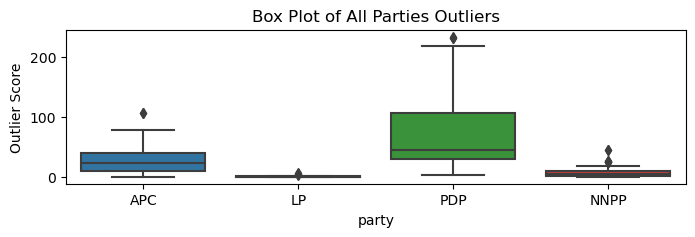

In [5]:
import seaborn as sns

# Box plot for outliers
def box_plot_outliers(data, party):
    plt.figure(figsize=(8, 2))
    sns.boxplot(x='party', y='outlier_score', data=data)
    plt.title(f'Box Plot of {party} Outliers')
    plt.ylabel('Outlier Score')
    plt.show()

# Combine all parties data
all_parties_data = data_with_outliers[data_with_outliers['party'].isin(['APC', 'LP', 'PDP', 'NNPP'])]

# Plot the box plot for outliers across all parties
box_plot_outliers(all_parties_data, 'All Parties')
